<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Forecasting Models

### Learning Objectives
 
**After this lesson, you will be able to:**
- Define time series analysis and time series forecasting models.
- Discuss the unique properties of time series models.
- Explore time series forecasting methods.

### Lesson Guide

#### Time Series: Forecasting Models
- [Time Series Models](#A)
- [Properties of Time Series Forecasting Models](#B)
- [Time Series Forecasting Methods](#C)
- [Independent Practice](#D)
----

### Installing StatsModels

We will use the StatsModels library to perform time series forecasting. This might already be installed in your Python environment, but it doesn't support the forecasting methods we'll be using in this lesson. So, we'll clone it from its repo and install it using the source code. To follow along with this lesson, complete these installation steps:

* In your terminal, use `pip freeze` to see if `statsmodels` is already installed in your environment.
* If it is, use `conda remove statsmodels`.
* Initialize Git in your terminal using `git init`.
* Clone the StatsModels repo by typing `git clone git://github.com/statsmodels/statsmodels.git` in your terminal.
* Change to the StatsModels directory with `cd statsmodels`.
* Build the set-up file using the`python setup.py build` command.
* When that is done, install it using `python setup.py install`.
* Exit out of the terminal.
* Restart the terminal.
* Open Python by typing `python`.
* Type `from statsmodels.tsa.api import ExponentialSmoothing` to verify the install. If you don't get any errors, you are all set!

<h2><a id="A">Time Series Models</a></h2>

**Time series analysis** comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. (The analyses we've been doing in previous section qualify as time series analysis).

**Time series forecasting** is the use of a model to predict future values based on previously observed values. We will discuss these types of models in this section. 

- Time series forecasting models predict a future value in a time series. Like other predictive models, we will use prior history to predict the future. Unlike previous models, however, we will use the _outcome_ variables from earlier in time as the _inputs_ for prediction.

- As with the modeling you're used to, we will have to evaluate different models to ensure that we have chosen the best one.

- So, we will want to evaluate on _test data_ to ensure that our model performs well on unseen data.

### What Makes Time Series Data Special?

Time series data are time dependent. So, the basic assumption of a linear regression model — that the observations are independent — falls apart. Often, time series data include some sort of trend or may have seasonality.

<h2><a id = "B">Properties of Time Series Forecasting Models</a></h2>

### Training and Testing Sets

Time series data have a natural temporal ordering, which makes them different from the studies we've seen in other lessons in which there was no natural ordering of observations. 

Because these data are ordered, we **cannot choose training and testing examples at random.** As we are attempting to predict _a sequence of future values_, we must train on values from earlier (in time) in our data and then test our values at the end of the period.

### Moving Averages and Autocorrelation

In previous sections, we learned about a few statistics for analyzing time series. A **moving average** is the average of *k* surrounding data points in time.

We also looked at autocorrelation the compute the relationship of the data with prior values.

**Autocorrelation** is how correlated a variable is with itself. Specifically, how related variables from earlier in time are with variables from later in time. Note the need for a mean value:

${\Huge R(k) = \frac{\operatorname{E}[(X_{t} - \mu)(X_{t-k} - \mu)]}{\sigma^2}}^*$

### Stationarity

The criteria for classifying a series as stationary indicate that:

* The mean of the series should not be a function of time, but rather should be a constant. The image below has the left-hand graph satisfying this condition, whereas the graph in red has a time-dependent mean.

![](assets/Mean_nonstationarity.png)

* The variance of the series should not be a function of time. This property is known as homoscedasticity. The following graph depicts what is and what is not a stationary series. (Notice the varying spread of distribution in the right-hand graph.)

![](assets/Var_nonstationarity.png)

* The covariance of the `i`th term and the `(i + m)`th term should not be a function of time. In the following graph, you'll notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time for the "red series."

![](assets/Cov_nonstationarity.png)

Why is this important? Many of the time series models work on the assumption that the time series is stationary. We can think of this as: If a time series has a particular behavior over time, there is a high probability that it will act similarly in the future. 

As always, these assumptions may not apply to raw real-world data. (In fact, they rarely do!) 

For example, typical stock market performance is not stationary. In this plot of Dow Jones performance since 1986, the mean is clearly increasing over time:

![](/assets/images/dow-jones.png)

How can we test this for stationarity? One way is by visualizing the data.

### Testing for Stationarity

Import the libraries and data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

drones = pd.read_csv('./gt_drone_racing.csv', header=1)
drones.columns = ['week','drone_racing_interest']
drones.head()

,week,drone_racing_interest
0,2014-11-09,2
1,2014-11-16,2
2,2014-11-23,4
3,2014-11-30,6
4,2014-12-07,7


Change the `week` column to a `datetime` object and make it the index of the DataFrame.

In [2]:
drones['week'] = pd.to_datetime(drones.week)
drones.set_index('week', inplace=True)
drones.head()

,drone_racing_interest
week,
2014-11-09,2
2014-11-16,2
2014-11-23,4
2014-11-30,6
2014-12-07,7


Plot the data.

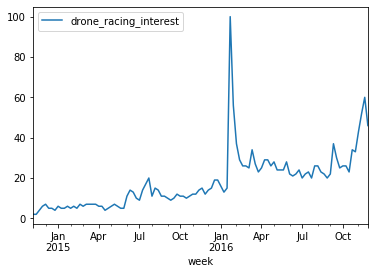

In [3]:
drones.plot();

It's clear that there is an overall increasing trend, as well as some seasonal variations. 

But, if this visual check for stationarity wasn't so clear, we could use the following:
* **Plotting rolling statistics**: This is another visual technique, but it can help us see if the moving average or moving variance varies over time. 
* **Dickey-Fuller test**: This is a statistical test for checking for stationarity. The null hypothesis of this test is that the time series is non-stationary. The Dickey-Fuller test returns a test statistic that is compared to a critical value for different confidence levels. If the test statistic is less than the critical value, we reject the null hypothesis and say that the time series is stationary.  

Here's a function for plotting rolling statistics and using the Dickey-Fuller test. We'll use it on our drone data. 

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determining rolling statistics:
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

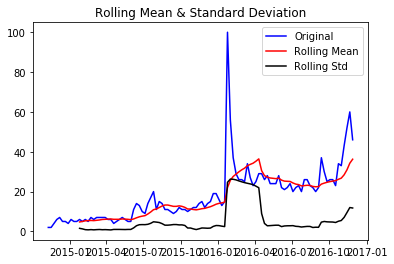

Results of Dickey-Fuller Test:
Test Statistic                  -3.811995
p-value                          0.002787
#Lags Used                       0.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [8]:
test_stationarity(drones.drone_racing_interest);

Although the variation in the standard deviation experiences one jump, the test statistic of the Dickey-Fuller test is less than the critical values and the p-value is less than each threshold. (Compare the signed values, not the absolute values). This is a stationary series. 

Let's discuss methods for making this time series stationary.

In [13]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        data series
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}
    regression : {'c','ct','ctt','nc'}
        Constant and trend order to include in regression
    
        * 'c' : constant only (default)
        * 'ct' : constant and trend
        * 'ctt' : constant, and linear and quadratic trend
        * 'nc' : no constant, no trend
    autolag : {'AIC', 'BIC', 't-stat', None}
        * if None, then maxlag lags are used
        * if 'AIC' (default) or 'BIC', then the number of lags is chosen
          to minimize the corresponding information 

### Making a Time Series Stationary

To make a time series stationary, we first need to understand what makes a it non-stationary. Two things can do this:

1) **Trend**: Variation over time. <br>
2) **Seasonality**: Variations at specific timeframes. <br>

### Detrending

We can preprocess our data to achieve stationarity. Two common methods are **detrending** and **differencing**.

**Detrending** removes major trends in our data. The simplest way is to fit a line to the trend, then make a new series of the difference between the line and the true series. 

Below are U.S. housing prices over time that demonstrate an upward trend. This makes the time series non-stationary, as the mean home price is increasing. The line fit through it represents the trend.

The bottom figure is the "detrended" data, where each data point is transformed by subtracting the value of the trend line at that point. This data now have a fixed mean and may be easier to model. This is similar to mean-scaling our features in earlier models with `StandardScaler`.

![](./assets/images/detrend.gif)

#### Example: Detrending

Fit a trendline to the data.

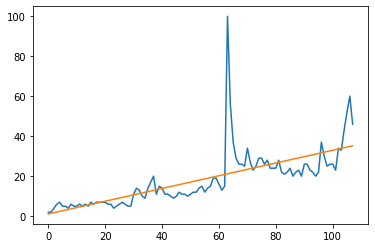

In [14]:
import numpy as np
import matplotlib.pyplot as plt
drones = pd.read_csv('./gt_drone_racing.csv', header=1)
drones.columns = ['week','drone_racing_interest']
coefs = np.polyfit(drones.index, drones.drone_racing_interest, 1)
lineFunction = np.poly1d(coefs)
plt.plot(drones.index, drones.drone_racing_interest, drones.index, lineFunction(drones.index));

Detrend the time series. In its simplest form, we literally subtract the trendline from the time series.

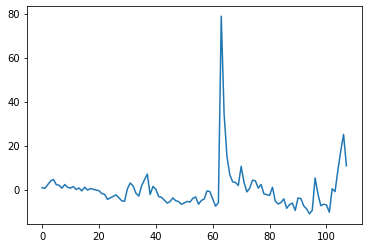

In [15]:
plt.plot(drones.index, drones.drone_racing_interest - lineFunction(drones.index));

There is also a helper function for this.

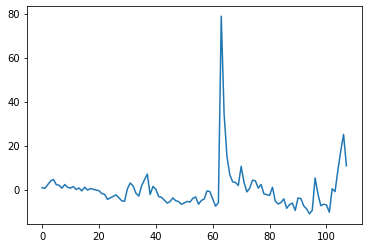

In [21]:
import scipy.signal
ffty = scipy.signal.detrend(drones.drone_racing_interest.values)
plt.plot(ffty);

### Differencing

A related method is **differencing**. Instead of predicting the (non-stationary) series, we can predict the difference between two consecutive values. **ARIMA** models incorporate this approach.

Recall that we used Pandas' `.diff()` method to find the difference in an earlier section.

#### Example: Differencing

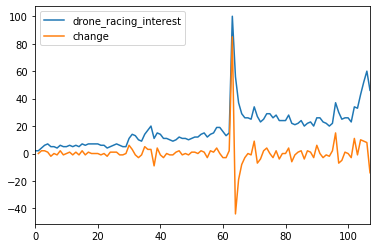

In [22]:
drones['change'] = drones.drone_racing_interest.diff(1);
drones.plot();

<h2><a id="C">Time Series Forecasting Methods</a></h2>

### Total RMSE from the Forecasting Methods below

In [67]:
rmse_list = list([rmse_1, rmse_2, rmse_3, rmse_4, rmse_5, rmse_6, rmse_7])

In [74]:
rmse_list

[121981.78781090611,
 144192.4921506529,
 188369.92416964,
 220538.43986419958,
 229155.36103495688,
 489261.9098353229,
 781856.6060449213]

In [73]:
print("Naive Method RMSE is {}".format(rmse_1))
print("Simple Average Method RMSE is {}".format(rmse_2))
print("Moving Average Method RMSE is {}".format(rmse_3))
print("Simple Exponential Smoothing Method RMSE is {}".format(rmse_4))
print("Holt's Linear Trend Method RMSE is {}".format(rmse_5))
print("Holt-Winters Method Method RMSE is {}".format(rmse_6))
print("ARIMA RMSE is {}".format(rmse_7))

Naive Method RMSE is 144192.4921506529
Simple Average Method RMSE is 121981.78781090611
Moving Average Method RMSE is 220538.43986419958
Simple Exponential Smoothing Method RMSE is 188369.92416964
Holt's Linear Trend Method RMSE is 781856.6060449213
Holt-Winters Method Method RMSE is 229155.36103495688
ARIMA RMSE is 489261.9098353229


### Method 1: Naive Approach

Let's look at Walmart's weekly sales data over a two-year period from 2010 to 2012. The data set is separated by store and department, but we'll focus on analyzing one store for simplicity.

#### Read in the data set and take a look at it.

In [23]:
walmart = pd.read_csv('./train.csv')
walmart.set_index('Date', inplace=True)
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the DataFrame to Store 1 sales and aggregate over departments to compute the total sales per store.

In [24]:
store1 = walmart[walmart.Store == 1]
store1_sales = pd.DataFrame(store1.Weekly_Sales.groupby(store1.index).sum())
store1_sales.reset_index(inplace = True)
store1_sales['Date'] = pd.to_datetime(store1_sales['Date'])
store1_sales.set_index('Date',inplace = True)

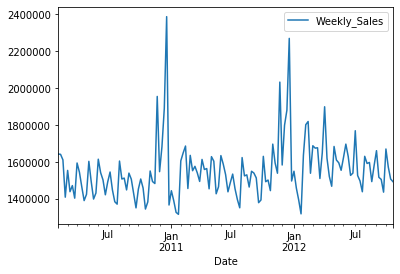

In [25]:
store1_sales.plot();

If we think sales have been stable from the start, we can simply take the last time period's sales and estimate the same value for the next time period. Such a forecasting technique, which assumes that the next expected point is equal to the last observed point, is called a **naive method**.

$$\hat y_{t+1} = y_t$$

We will subset the data to look at the accuracy of each time series forecasting method on the data set. We'll use the first two years (2010–2011) as the "training" data and the last year (2012) as the "testing" data for the purposes of our demonstration.  

In [26]:
train = store1_sales['2010': '2011']
test = store1_sales['2012']

Let's plot the data to take a look at the subsetting.

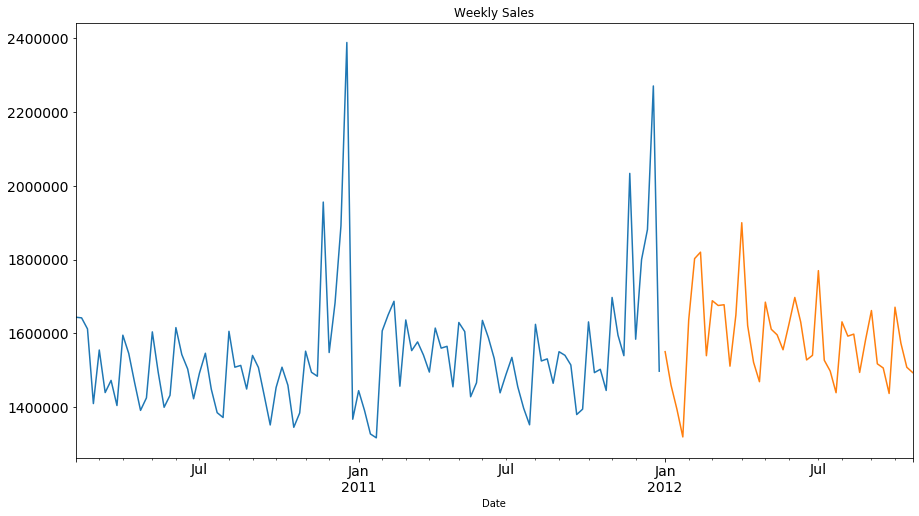

In [27]:
train.Weekly_Sales.plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
test.Weekly_Sales.plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
plt.show();

#### Let's see how the well the naive method does when forecasting sales.

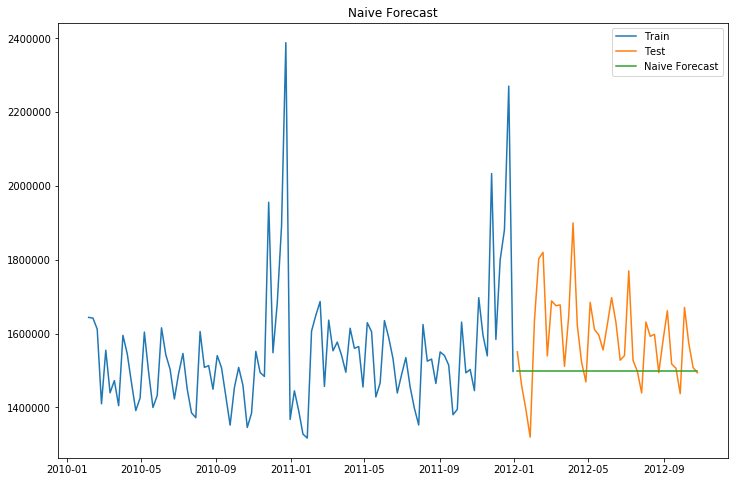

In [28]:
dd= np.asarray(train.Weekly_Sales)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Weekly_Sales'], label='Train')
plt.plot(test.index,test['Weekly_Sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show();

Let's use RMSE to check the accuracy of our model on the test data set.

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_1 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat.naive))
print(rmse_1)

144192.4921506529


We can infer from the RMSE value and the graph above that the naive method isn’t suited for data sets with high variability. It's best suited for stable data sets. We can still improve our score by adopting different techniques, however. Let's try a different technique to attempt to improve the accuracy score.

### Method 2: Simple Average

**Simple average** is a useful method when the values of interest are increasing and decreasing randomly by a small margin but the average remains constant. Simple average forecasts the weekly sales of the next time period to be somewhat similar to the average of all of the previous time periods. 

$$\hat y_{t+1} = \dfrac{1}{x} \sum_{i=1}^{x} y_i$$

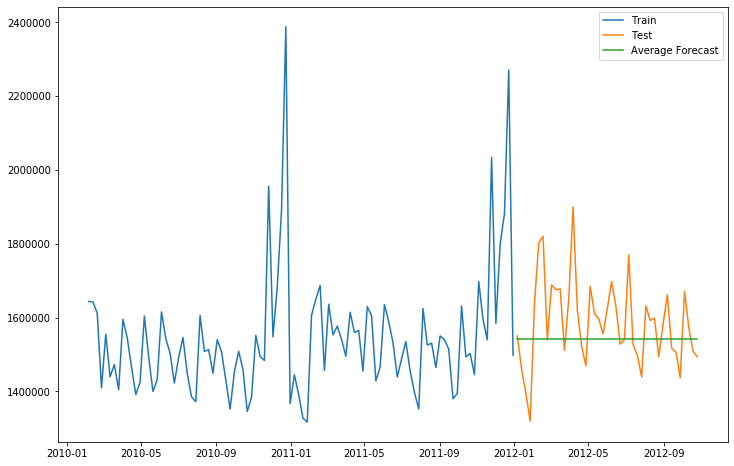

In [30]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Weekly_Sales'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show();

Now, let's calculate RMSE to check to accuracy of our model.

In [31]:
rmse_2 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat_avg.avg_forecast))
print(rmse_2)

121981.78781090611


This model improved the score a bit. The simple average method works best when the average at each time period remains constant.

### Method 3: Moving Average

When we have data sets in which the sales/value has increased or decreased sharply some time periods ago, simply using the previous average of all of the data (like the simple average method) isn't appropriate. An improvement over the simple average in this case will only take the average of the sales for the last few time periods, as we are think that only recent values may matter. This is called the **moving average** technique and it uses a sliding time period window to calculate the average. 

Using a simple moving average model, we forecast the next value(s) in a time series based on the average of a fixed finite number (`p`) of the previous values. Thus, for all `i > p`:

$$\hat y_{t+1} = \dfrac{1}{p} (y_{i-1} + y_{i-2} + y_{i-3} + ... + y_{i-p})$$

A moving average can be quite effective if you pick the right `p` for the series.

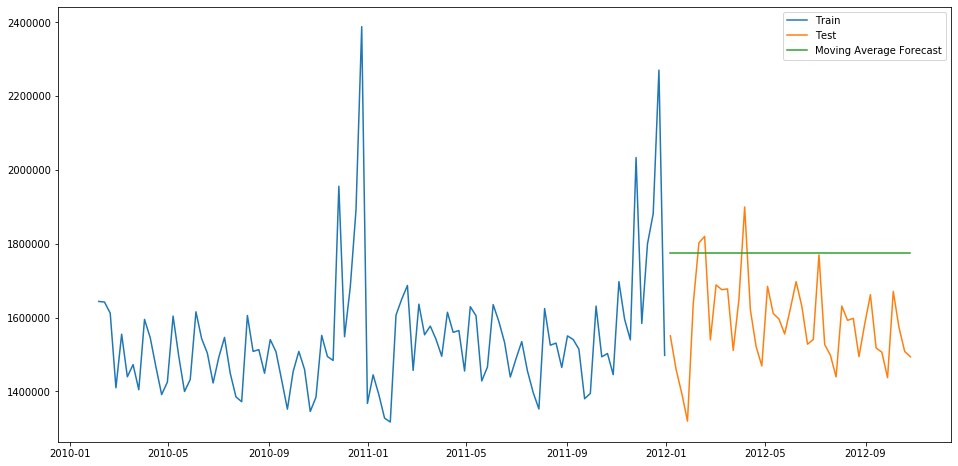

In [32]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Weekly_Sales'].rolling(8).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show();

We chose the data from the last eight weeks. We will now calculate RMSE to check to accuracy of our model.

In [33]:
rmse_3 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat_avg.moving_avg_forecast))
print(rmse_3)

220538.43986419958


This didn't perform very well. Perhaps we picked an incorrect `p`, or perhaps this method isn't the best for our data set.

An advancement over the moving average method is the **weighted moving average** method. In the moving average method, we weigh the past `n` observations equally. But, we might encounter situations where each of the observations from the past `n` impacts the forecast in a different way. Typically, weights are chosen so that more recent points matter more. 

$$\hat y_{t+1} = \dfrac{1}{p} (w_1*y_{i-1} + w_2*y_{i-2} + w_3*y_{i-3} + ... + w_p*y_{i-p})$$

### Method 4: Simple Exponential Smoothing 

Simple average and weighted moving average lie on opposite sides of the spectrum. **Simple exponential smoothing** lies between these two extremes and takes into account all of the data while weighing the data points differently. Simple exponential smoothing will calculate the forecast using weighted averages where the weights decrease exponentially as observations come from further in the past (the closet data points in time are weighted more heavily). 

$$\hat y_{t+1} = \alpha y_t + \alpha (1-\alpha)y_{t-1} + (1-\alpha)^2 y_{t-2} + ...$$

The one-step-ahead forecast for time `t+1` is a weighted average of all of the observations in the series (`y1,…,yt`). The rate at which the weights decrease is controlled by the parameter, `α` (which is between 0 and 1).

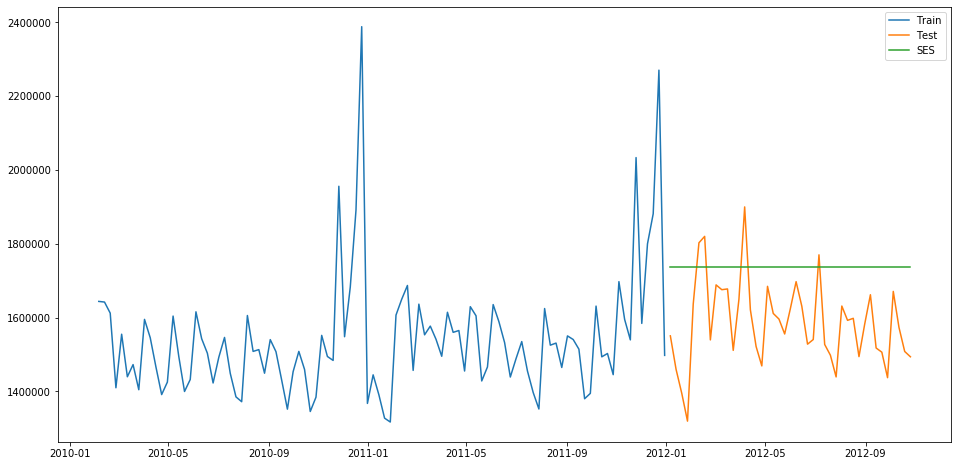

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Weekly_Sales'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show();

Now, let's use RMSE to check to accuracy of our model.

In [35]:
rmse_4 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat_avg.SES))
print(rmse_4)

188369.92416964


### Method 5: Holt's Linear Trend

The methods we've looked at so far don't do well when our data have high variations. If our data contain a trend, none of the previous methods would be able to take that into account. A method that can is **Holt's linear trend** method. 

Recall that a time series data set can be decomposed into its trend, seasonality, and residual components. If the data set contains a trend, then Holt's linear trend method can be applied. 

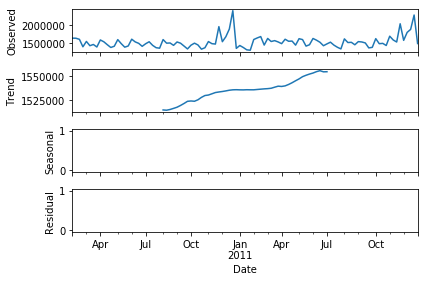

In [36]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Weekly_Sales).plot()
result = sm.tsa.stattools.adfuller(train.Weekly_Sales)
plt.show();

From these graphs, we can see that the data set follows an increasing trend, and we can use Holt's linear trend method to forecast the future sales. 

Holt's linear trend is exponential smoothing applied to both the average value of the series (called "level") and trend. 

To generate the forecasting equation, we will add these equations together. 

<h3><center>Level Equation</center></h3>: $$\ell_t = \alpha y_t + (1 - \alpha)(\ell_{t-1} + b_{t-1})$$ 
<h3><center>Trend Equation</center></h3>: $$b_t = \beta *(\ell_t - \ell_{t-1}) + (1 - \beta)b_{t-1}$$

We will add these equations together to generate the forecast equation. 

<h3><center>Forecast Equation</center></h3>: 
$$\hat y_{t+h|1}= \ell_t + hb_t $$

We could have also multiplied the trend and level together to generate a multiplicative forecast equation. When the trend is linear, the additive equation is used. When the trend is exponential, the multiplicative equation is used. The multiplicative equation is usually a more stable predictor (but the additive is more intuitive). 

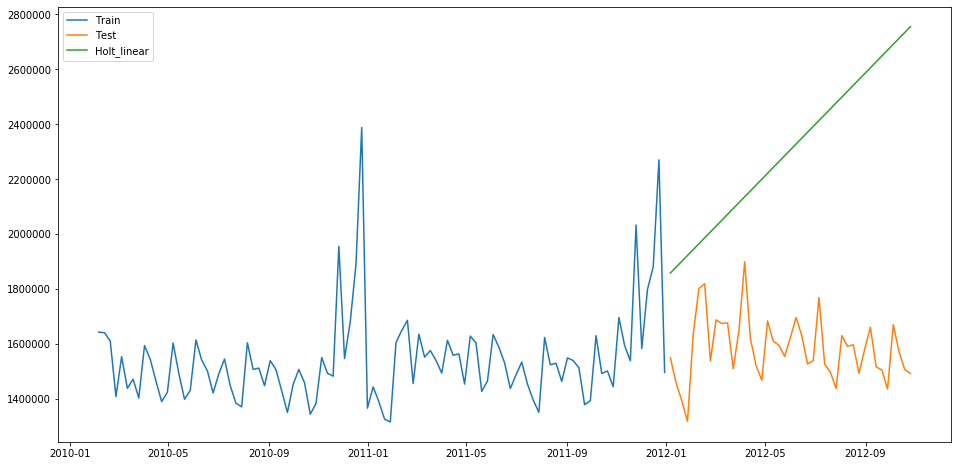

In [37]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Weekly_Sales'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show();

In [38]:
rmse_5 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat_avg.Holt_linear))
print(rmse_5)

781856.6060449213


### Method 6: Holt-Winters Method

So far, we haven't taken into account the seasonality of the data set while forecasting. **Holt's Winter** method takes into account both trend and seasonality to forecast future sales. With this method, we will apply exponential smoothing to the seasonal components as well as the level and trend components. 

<h3><center>Level Equation</center></h3>: $$L_t = \alpha (y_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + b_{t-1})$$ 
<h3><center>Trend Equation</center></h3>: $$b_t = \beta *(L_t - L_{t-1}) + (1 - \beta)b_{t-1}$$
<h3><center>Seasonality Equation</center></h3>: $$S_t = \gamma(y_t-L_t)+(1-\gamma)S_{t-s}$$
<h3><center>Forecast Equation</center></h3>: $$F_{t+k} = L_t + kb_t+S_{t+k-s}$$

(Where `α`, `β`, and `γ` are the smoothing parameters — each between 0 and 1 — and `s` is the length of the seasonal cycle.)

The trend equation is identical to the equation we used for Holt's linear trend method. The level equation is a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time `t`. The seasonal equation is a weighted average between the current seasonal index and the seasonal index of the same season `s` time periods ago. 

Just like in Holt's linear trend method, we can use either additive or multiplicative forecasting equations. When the seasonal variations are roughly constant throughout the series, we will use the additive method. When the seasonal variations change depending on the level of the series, we will use the multiplicative method. 

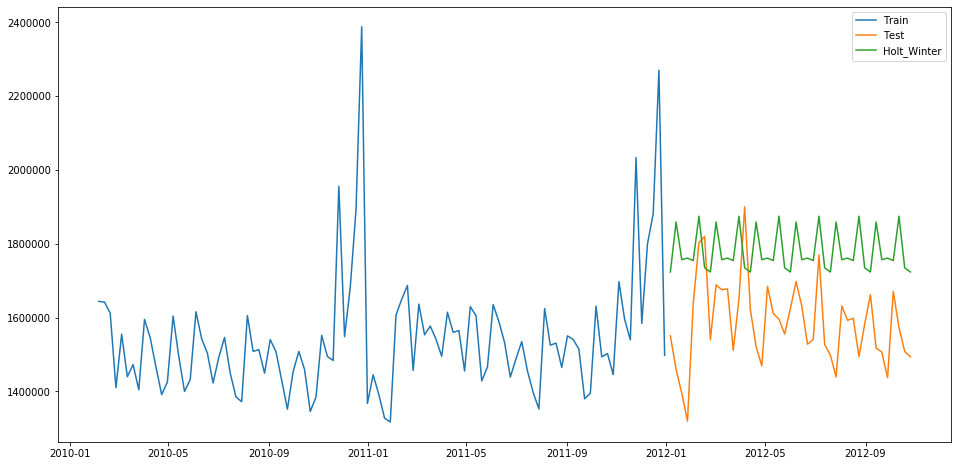

In [39]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Weekly_Sales']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

Let's look at the RMSE to check accuracy.

In [40]:
rmse_6 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat_avg.Holt_Winter))
print(rmse_6)

229155.36103495688


### Method 7: ARIMA

A very popular forecasting method is **ARIMA**, which stands for **autoregressive integrated moving average.** With the exponential smoothing methods we've been using, we've been basing our forecasts on the trend and seasonality in the data. ARIMA models describe the correlations in the data with each other. 

The **seasonal ARIMA** takes into account seasonality (like Holt's Winter method did).

We can use the ACF and PACF to pick a model and our parameters for ARIMA.

#### Using the ACF and PACF Plots to Pick a Model

Recall from the section on autocorrelation that the autocorrelation function (ACF) is a plot of total correlation between different lag functions. 

In a moving average series of lag `n`, we will not get any correlation between `x(t)` and `x(t – n -1)`, so the total correlation chart cuts off at `n`th lag. In other words, we can determine the lag for an MA series by when the ACF drops off sharply. For an AR series, this correlation will gradually go down without any cut-off value.

If the ACF tells us it is an AR series, then we turn to the PACF. If we find out the partial correlation of each lag, it will cut off after the degree of the AR series. For instance, if we have a AR(1) series, if we exclude the effect of first lag (`x (t-1)`), our second lag (`x (t-2)`) is independent of `x(t)`. Hence, the partial correlation function (PACF) will drop sharply after the first lag.

#### ARIMA Model

/Users/tiffanykelly/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


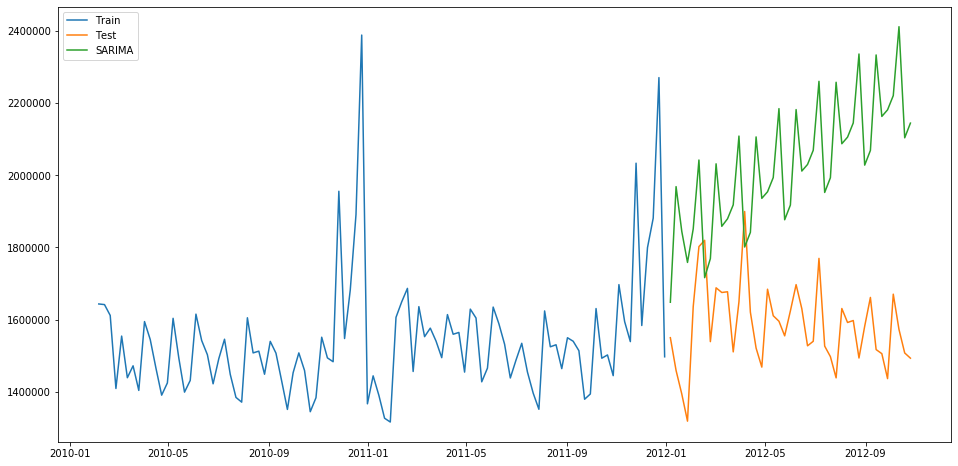

In [42]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train['Weekly_Sales'], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict( start="2012-01-06", end="2012-10-26", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

Let's check the RMSE for accuracy of the model.

In [43]:
rmse_7 = sqrt(mean_squared_error(test.Weekly_Sales, y_hat_avg.SARIMA))
print(rmse_7)

489261.9098353229
